In [0]:
from google.colab import drive  # if you importing dataset from your google drive, use this code
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset Link :** https://www.aicrowd.com/challenges/spotify-sequential-skip-prediction-challenge


Upon access to link, click Resouces tab to access various datasets.

# Importing Datasets

In [0]:
train_path = "/content/drive/My Drive/Spotify datasets/Training_data/"  #input train dataset directory path
track_path = "/content/drive/My Drive/Spotify datasets/Track_features/" #input track features directory path
test_path = "/content/drive/My Drive/Spotify datasets/Test_data/"       #input test dataset directory path

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# from dython.nominal import associations 
from sklearn import preprocessing
from keras.preprocessing import sequence
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Flatten, Input, concatenate, CuDNNLSTM, Concatenate, TimeDistributed, Reshape
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from keras import Model

Using TensorFlow backend.


In [0]:
training_dir = train_path
track_dir = track_path
test_dir = test_path

In [0]:
#training sets
train_0715 = pd.read_csv(training_dir+"log_0_20180715_000000000000.csv")

In [0]:
#test sets
test_0715 = pd.read_csv(test_dir + "log_input_20180715_000000000000.csv")

In [0]:
#track_features
track_00 = pd.read_csv(track_dir + "tf_000000000000.csv")
track_01 = pd.read_csv(track_dir + "tf_000000000001.csv")

In [0]:
train_df = train_0715

In [0]:
track_features = pd.concat([track_00,track_01])
track_features = track_features.reset_index()

# EDA

## Visualising Distributions of Variables

In [0]:
discrete_cols = ["skip_1", "skip_2", "skip_3", "not_skipped", "context_switch", "no_pause_before_play", "short_pause_before_play", "long_pause_before_play", "hist_user_behavior_n_seekfwd", "hist_user_behavior_n_seekback", "hist_user_behavior_is_shuffle", "mode", "key", "premium", "context_type", "hist_user_behavior_reason_start", "hist_user_behavior_reason_end", "time_signature"]
cont_cols = ["release_year", "hour_of_day", "duration", "us_popularity_estimate", "acousticness", "beat_strength", "bounciness", "danceability", "dyn_range_mean", "energy", "flatness", "instrumentalness", "liveness", "loudness", "mechanism", "organism", "speechiness", "tempo", "valence", "acoustic_vector_0", "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3", "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6", "acoustic_vector_7"]

In [0]:
target_cols = ['skip_1', "skip_2", "skip_3", "not_skipped"]
sizes = []
for col in target_cols:
  sizes.append(len(final_data[final_data[col] == 0]))

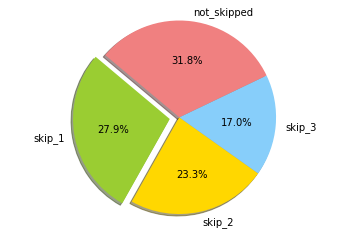

In [0]:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

explode = (0, 0, 0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=target_cols, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

### Histogram for Continuous Variables

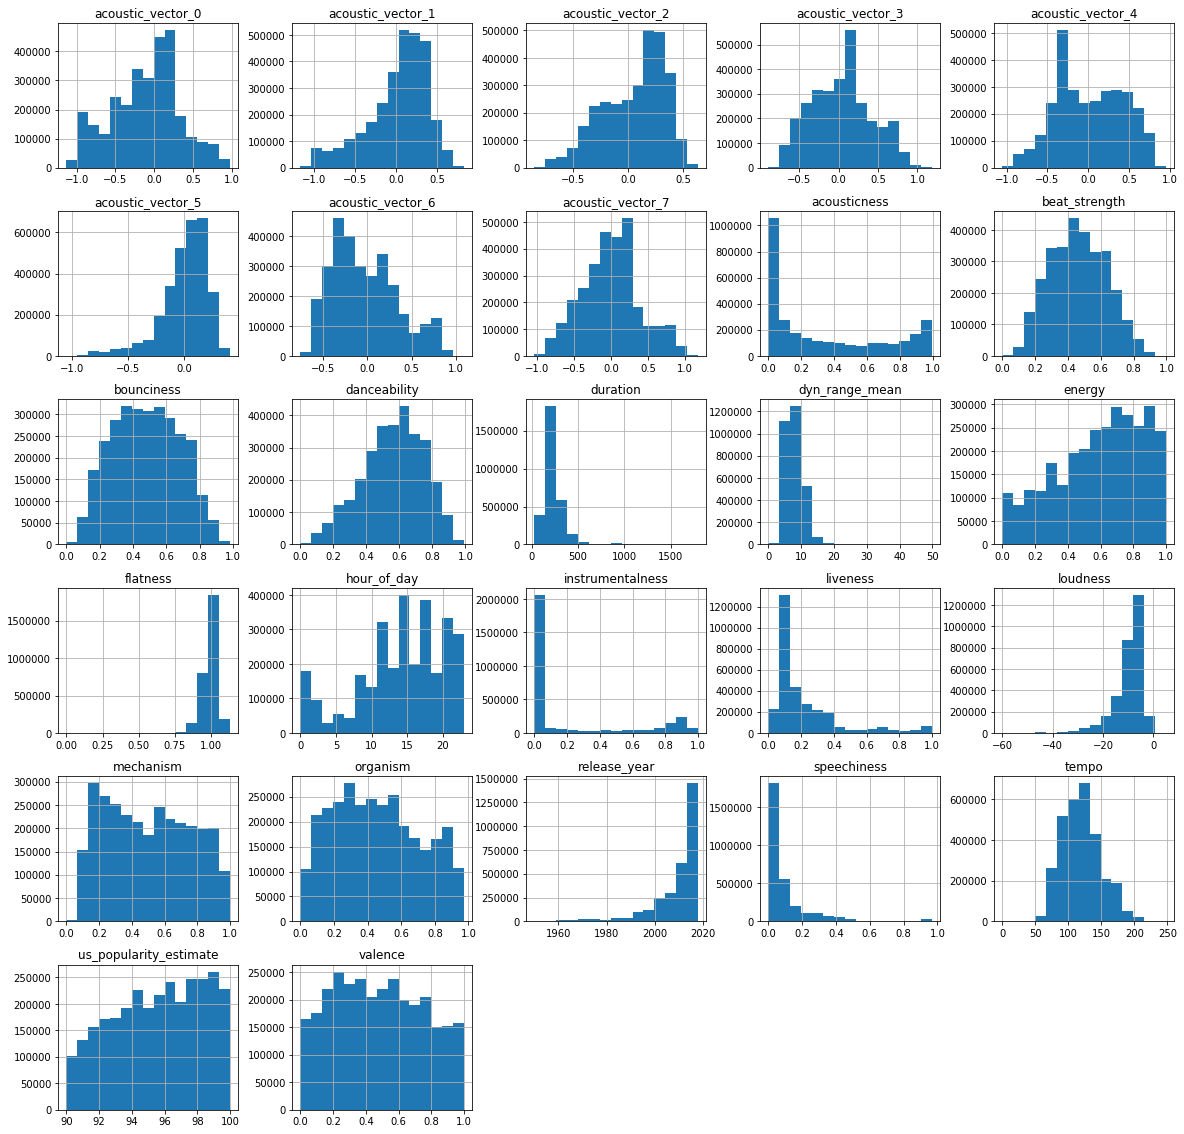

In [0]:
# plotting histograms for continuous variables
final_data[cont_cols].hist(bins=15, figsize=(20, 20), layout=(6, 5));

### Box Plots for Continuous Variables

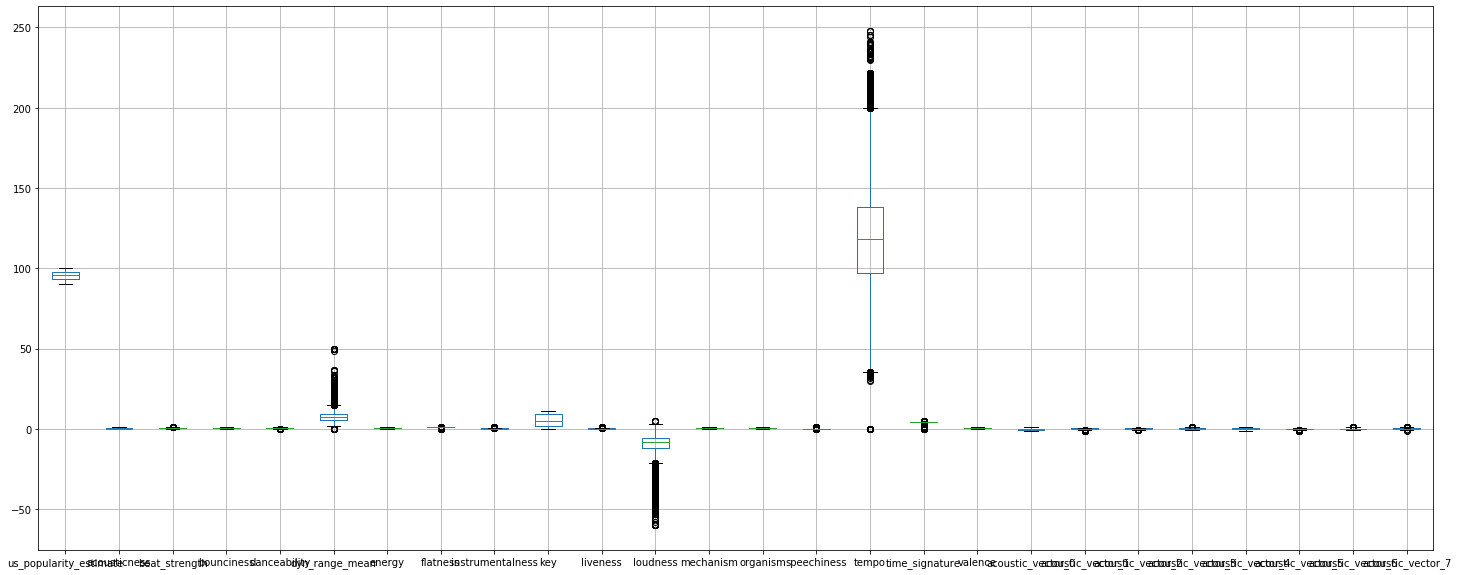

In [0]:
final_data.boxplot(column=["us_popularity_estimate","acousticness", "beat_strength", "bounciness", 
      "danceability", "dyn_range_mean", "energy", "flatness",
      "instrumentalness", "key", "liveness", "loudness", 
      "mechanism", "organism", "speechiness", "tempo",
      "time_signature", "valence", "acoustic_vector_0",
      "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3",
      "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6",
      "acoustic_vector_7"], figsize = (25,10))

### Bar Graphs for Discrete Variables

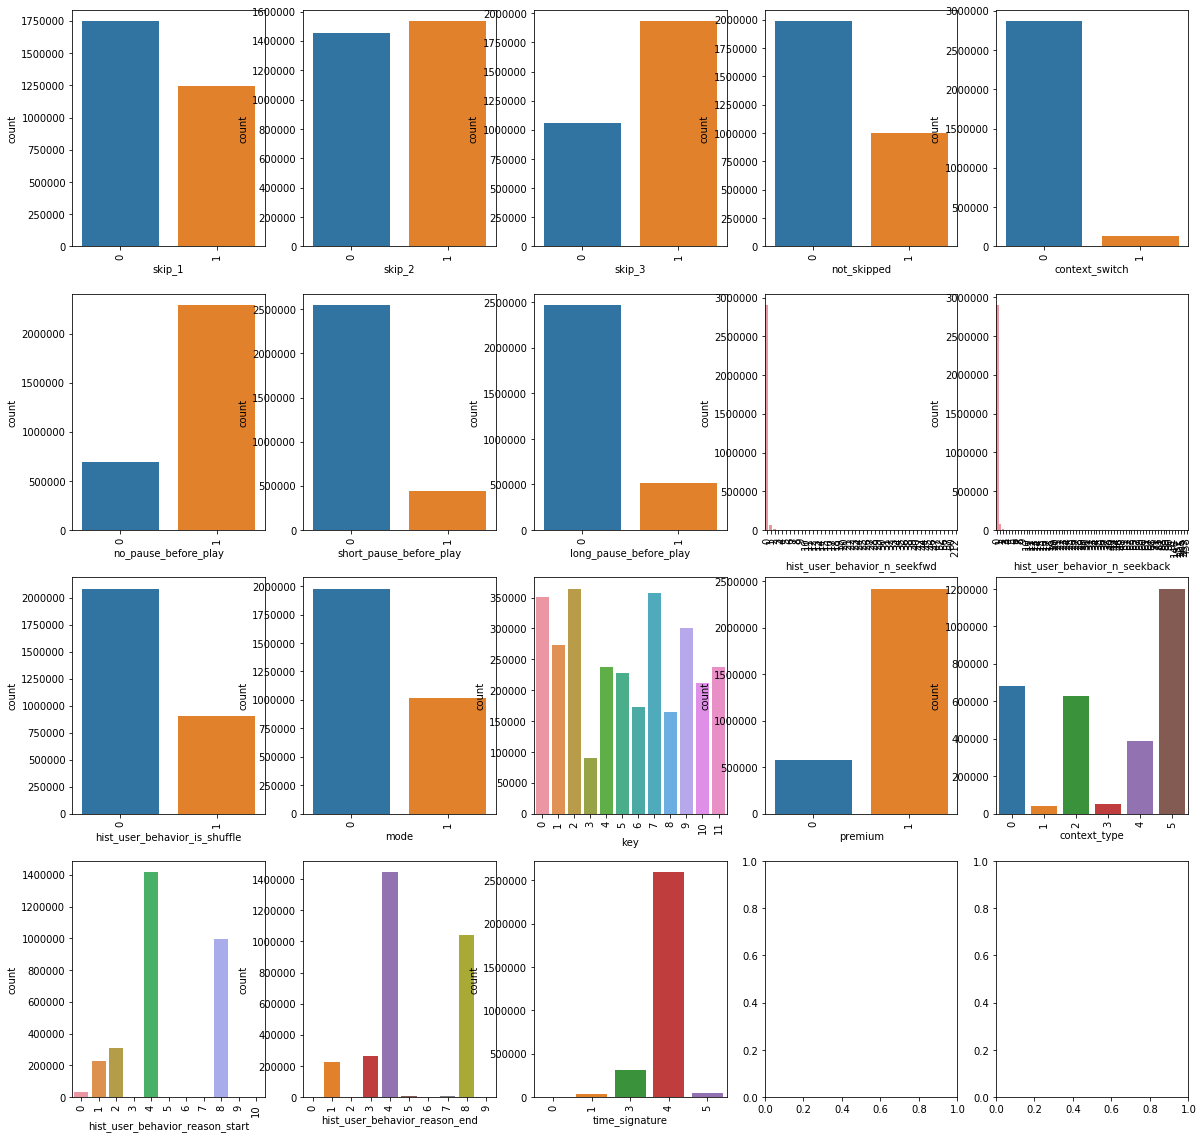

In [0]:
# plotting bar graphs for discrete variables
fig, ax = plt.subplots(4, 5, figsize=(20, 20))

for variable, subplot in zip(discrete_cols, ax.flatten()):  
    sns.countplot(final_data[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)


## Data Smoothing and Encoding

In [0]:
# -- DATA SMOOTHING: Reassigning session id to a clearer naming convention -- #
data = train_df
new_session_id = []
session_num = 0

data["prev_id"] = data["session_id"].shift(1)

for row in data.itertuples():
    if row.session_id == row.prev_id:
        new_session_id.append(session_num)
    elif row.session_id != row.prev_id:
        session_num+=1
        new_session_id.append(session_num)

data["new_session_id"] = new_session_id

#cols = ["new_session_id"] + [col for col in session if col!="new_session_id"]

#session = session[cols]


# -- DATA SMOOTHING: Encoding track_id to numeric digits -- #
data["track_id_clean"] = data["track_id_clean"].astype('category')
data["track_id_enc"] = data["track_id_clean"].cat.codes


del data["prev_id"]
del data["session_id"]
del data["track_id_clean"]

columnTitles = ['new_session_id', 'session_position', 'session_length', 'track_id_enc', 
                'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch', 
               'no_pause_before_play', 'short_pause_before_play', 'long_pause_before_play', 
               'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback', 
               'hist_user_behavior_is_shuffle', 'hour_of_day', 'date', 'premium', 'context_type',
               'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']

data = data.reindex(columns=columnTitles)

In [0]:
track_features["track_id"] = track_features["track_id"].astype('category')
track_features["track_id_enc"] = track_features["track_id"].cat.codes

cols = ["track_id_enc"] + [col for col in track_features if col!="track_id_enc"]

track_features = track_features[cols]

del track_features["track_id"]

In [0]:
data.skip_2 = data.skip_2.astype(int)
data.hist_user_behavior_is_shuffle = data.hist_user_behavior_is_shuffle.astype(int)
data.premium = data.premium.astype(int)

In [0]:
scaler = preprocessing.MinMaxScaler()

cols_to_norm = ["us_popularity_estimate","acousticness", "beat_strength", "bounciness", 
      "danceability", "dyn_range_mean", "energy", "flatness",
      "instrumentalness", "key", "liveness", "loudness", 
      "mechanism", "organism", "speechiness", "tempo",
      "time_signature", "valence", "acoustic_vector_0",
      "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3",
      "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6",
      "acoustic_vector_7"]

track_features[cols_to_norm] = scaler.fit_transform(track_features[cols_to_norm])  

In [0]:
final_data = pd.merge(data, track_features, on='track_id_enc')

In [0]:
final_data = final_data.drop(columns = ['skip_1', 'skip_3', 'not_skipped', 'date'], axis = 1)

In [0]:
final_data["context_type"] = final_data["context_type"].astype('category')
c = final_data["context_type"].astype('category')
d = dict(enumerate(c.cat.categories))
print (d)
final_data["context_type"] = final_data["context_type"].cat.codes

{0: 'catalog', 1: 'charts', 2: 'editorial_playlist', 3: 'personalized_playlist', 4: 'radio', 5: 'user_collection'}


In [0]:
final_data["hist_user_behavior_reason_start"] = final_data["hist_user_behavior_reason_start"].astype('category')
c = final_data["hist_user_behavior_reason_start"].astype('category')
d = dict(enumerate(c.cat.categories))
print (d)
final_data["hist_user_behavior_reason_start"] = final_data["hist_user_behavior_reason_start"].cat.codes

{0: 'appload', 1: 'backbtn', 2: 'clickrow', 3: 'endplay', 4: 'fwdbtn', 5: 'playbtn', 6: 'popup', 7: 'remote', 8: 'trackdone', 9: 'trackerror', 10: 'uriopen'}


In [0]:
final_data["hist_user_behavior_reason_end"] = final_data["hist_user_behavior_reason_end"].astype('category')
c = final_data["hist_user_behavior_reason_end"].astype('category')
d = dict(enumerate(c.cat.categories))
print (d)
final_data["hist_user_behavior_reason_end"] = final_data["hist_user_behavior_reason_end"].cat.codes

{0: 'appload', 1: 'backbtn', 2: 'clickrow', 3: 'endplay', 4: 'fwdbtn', 5: 'logout', 6: 'popup', 7: 'remote', 8: 'trackdone', 9: 'uriopen'}


In [0]:
final_data["mode"] = final_data["mode"].astype('category')
c = final_data["mode"].astype('category')
d = dict(enumerate(c.cat.categories))
print (d)
final_data["mode"] = final_data["mode"].cat.codes

{0: 'major', 1: 'minor'}


In [0]:
#context type : {0: 'catalog', 1: 'charts', 2: 'editorial_playlist', 3: 'personalized_playlist', 4: 'radio', 5: 'user_collection'}
#hist_user_behavior_reason_start : {0: 'appload', 1: 'backbtn', 2: 'clickrow', 3: 'endplay', 4: 'fwdbtn', 5: 'playbtn', 6: 'popup', 7: 'remote', 8: 'trackdone', 9: 'trackerror', 10: 'uriopen'}
#hist_user_behavior_reason_end	: {0: 'appload', 1: 'backbtn', 2: 'clickrow', 3: 'endplay', 4: 'fwdbtn', 5: 'logout', 6: 'popup', 7: 'remote', 8: 'trackdone', 9: 'uriopen'}


In [0]:
final_data.sort_values(['new_session_id','session_position'],inplace=True)

In [0]:
final_data = final_data.reset_index()

In [0]:
final_data = final_data.drop(columns=['level_0'],axis=1)

In [0]:
first_half = final_data.loc[lambda x: x.session_position <= (x.session_length/2)].copy()
second_half = final_data.loc[lambda x: x.session_position > (x.session_length/2)].copy()

## Data Transformation and Standardisation


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f167cc62ba8>,
      dtype=object)

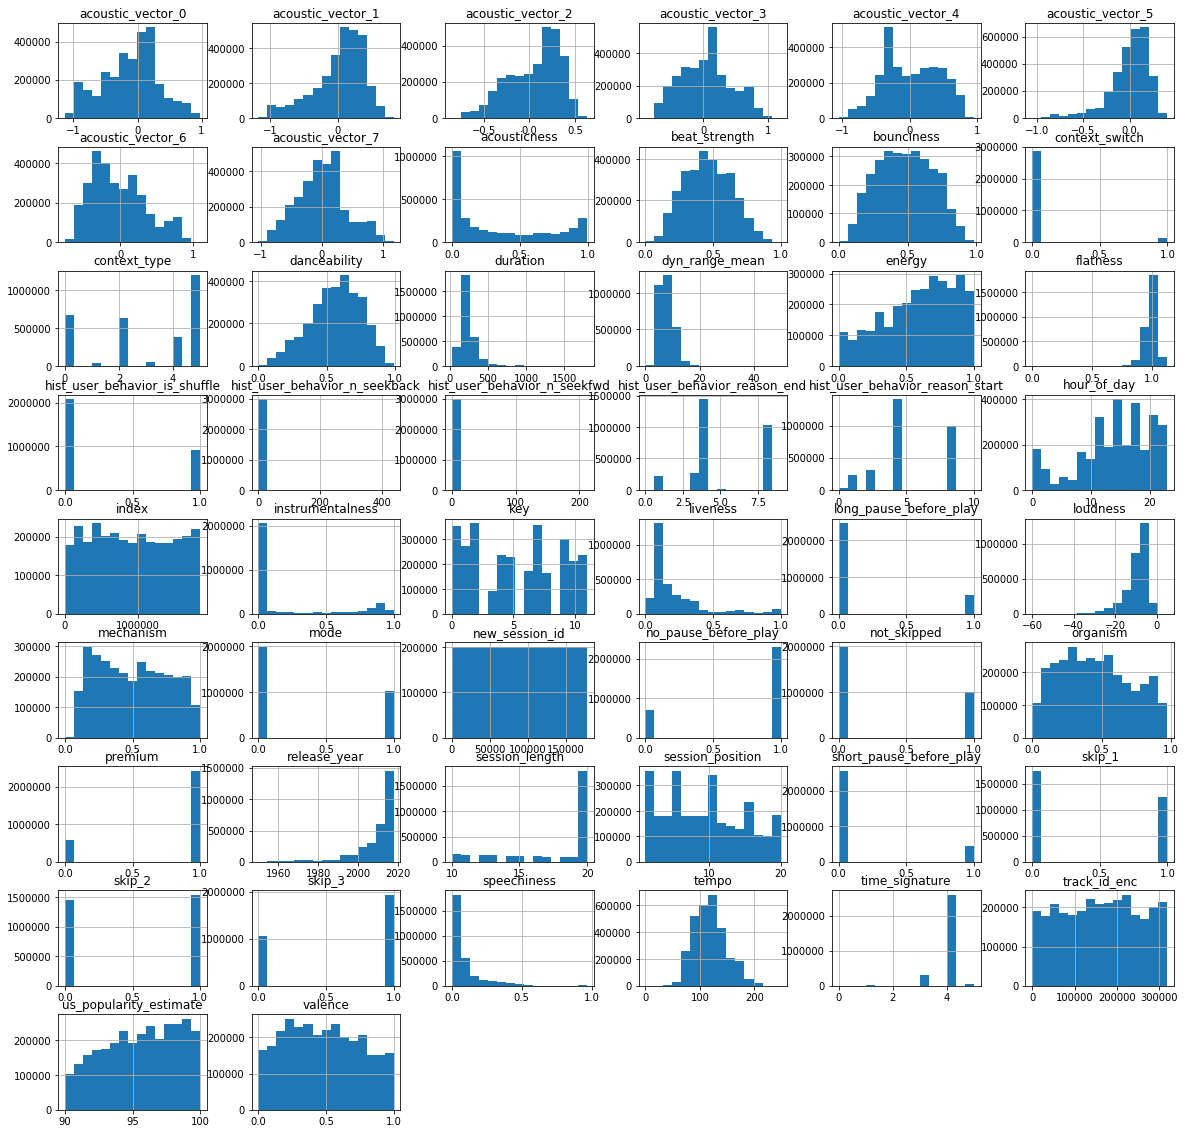

In [0]:
## plotting the distribution histogram to visualise 
# finding out the skewed variables to be transformed
final_cols = final_data.columns
final_data[final_cols].hist(bins=15, figsize=(20, 20), layout=(9, 6))

In [0]:
left_skewed = ['acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_5', 'loudness'] # Exp
right_skewed = ['acousticness', 'instrumentalness', 'liveness', 'speechiness'] # log 

In [0]:
import math
def exponential(x):
  return float(math.exp(x))

def logarithm(x):
  return math.log(x+1)

for col in left_skewed:
  final_data[col].apply(exponential)

for col in right_skewed:
  final_data[col].apply(logarithm)

In [0]:
# Normalisation
scaler = preprocessing.MinMaxScaler()

cols_to_norm = ["us_popularity_estimate","acousticness", "beat_strength", "bounciness", 
      "danceability", "dyn_range_mean", "energy", "flatness",
      "instrumentalness", "key", "liveness", "loudness", 
      "mechanism", "organism", "speechiness", "tempo",
      "time_signature", "valence", "acoustic_vector_0",
      "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3",
      "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6",
      "acoustic_vector_7"]

final_data[cols_to_norm] = scaler.fit_transform(final_data[cols_to_norm])  

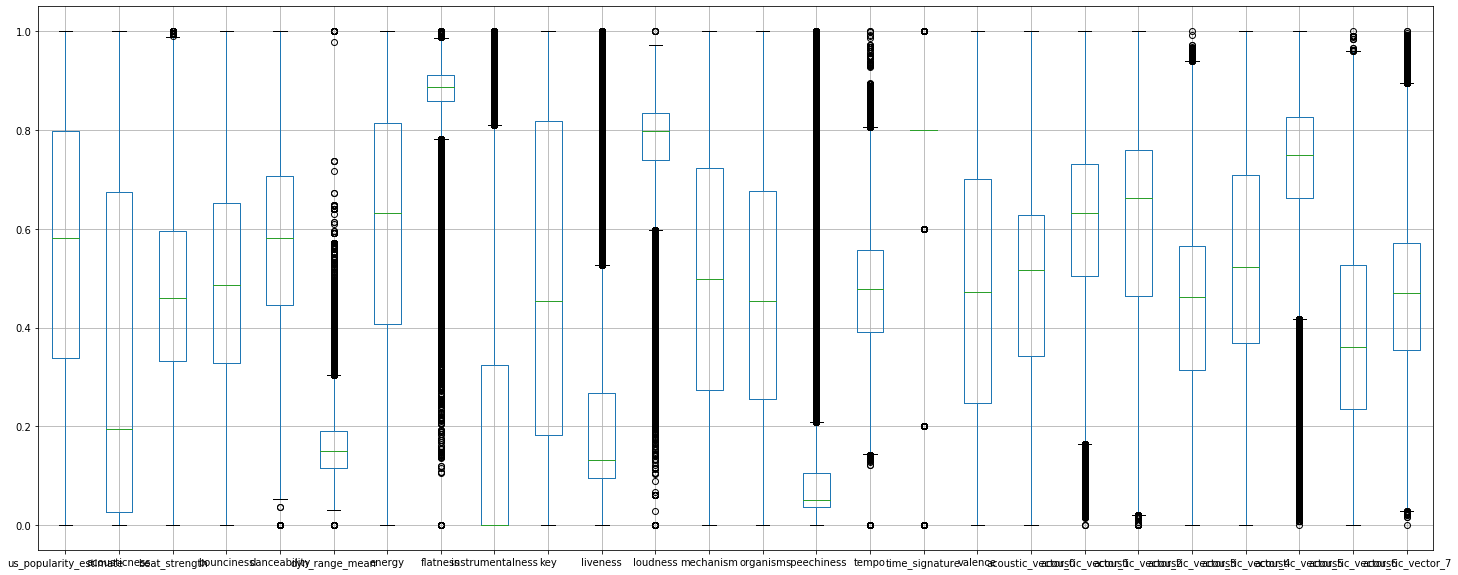

In [0]:
# Checking distribution after standardisation and transformation
final_data.boxplot(column=["us_popularity_estimate","acousticness", "beat_strength", "bounciness", 
      "danceability", "dyn_range_mean", "energy", "flatness",
      "instrumentalness", "key", "liveness", "loudness", 
      "mechanism", "organism", "speechiness", "tempo",
      "time_signature", "valence", "acoustic_vector_0",
      "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3",
      "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6",
      "acoustic_vector_7"], figsize = (25,10))

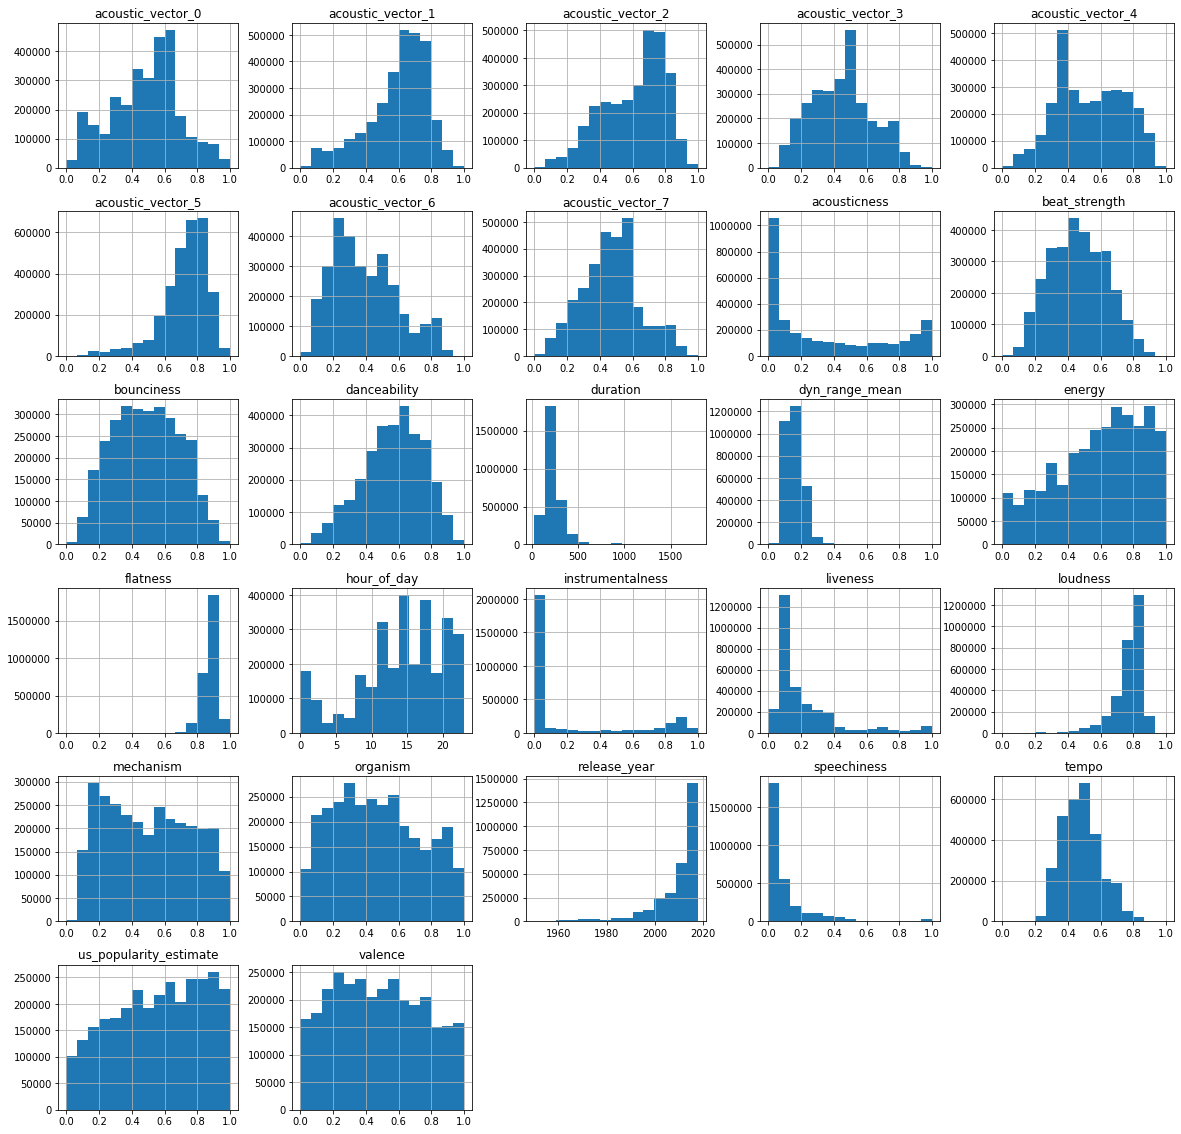

In [0]:
# plotting histograms for continuous variables
final_data[cont_cols].hist(bins=15, figsize=(20, 20), layout=(6, 5));

In [0]:
final_data.describe()

,new_session_id,session_position,session_length,track_id_enc,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,index,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06,2.990609e+06
mean,8.918187e+04,9.312991e+00,1.762598e+01,1.613297e+05,4.159892e-01,5.127504e-01,6.457233e-01,3.359543e-01,4.242681e-02,7.666128e-01,1.473198e-01,1.737532e-01,3.958525e-02,4.301465e-02,3.030878e-01,1.413181e+01,8.088767e-01,3.014478e+00,4.852421e+00,5.080195e+00,9.227255e+05,2.370807e+02,2.009407e+03,5.572305e-01,3.465216e-01,4.649891e-01,4.898670e-01,5.669029e-01,1.577073e-01,5.935153e-01,8.795547e-01,2.075869e-01,4.763610e-01,2.172736e-01,7.747516e-01,5.038863e-01,3.384408e-01,4.724986e-01,1.081711e-01,4.818449e-01,7.741455e-01,4.802918e-01,4.875791e-01,5.968630e-01,6.108400e-01,4.504563e-01,5.342240e-01,7.236544e-01,3.958236e-01,4.711949e-01
std,5.147737e+04,5.449092e+00,3.414523e+00,9.091299e+04,4.928917e-01,4.998375e-01,4.782936e-01,4.723231e-01,2.015609e-01,4.229866e-01,3.544245e-01,3.788972e-01,3.620769e-01,5.537631e-01,4.595929e-01,6.036343e+00,3.931860e-01,2.011643e+00,2.428195e+00,2.277814e+00,5.387427e+05,1.111346e+02,1.078512e+01,2.739646e-01,3.525352e-01,1.704231e-01,2.023328e-01,1.867909e-01,5.341517e-02,2.646755e-01,4.528616e-02,3.442733e-01,3.266402e-01,2.038921e-01,8.882062e-02,2.573921e-01,4.731793e-01,2.624715e-01,1.400504e-01,1.178438e-01,9.425871e-02,2.713590e-01,2.066660e-01,1.833664e-01,1.906126e-01,1.840011e-01,2.049565e-01,1.451962e-01,2.005613e-01,1.765693e-01
min,1.000000e+00,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.001333e+01,1.950000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.460200e+04,5.000000e+00,1.500000e+01,8.330700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,1.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00,4.527510e+05,1.776933e+02,2.006000e+03,3.379490e-01,2.573562e-02,3.318761e-01,3.280255e-01,4.449427e-01,1.163186e-01,4.065139e-01,8.588508e-01,2.400711e-07,1.818182e-01,9.553126e-02,7.390022e-01,2.735043e-01,0.000000e+00,2.553706e-01,3.780300e-02,3.914412e-01,8.000000e-01,2.468397e-01,3.417290e-01,5.039965e-01,4.634894e-01,3.139430e-01,3.686366e-01,6.621266e-01,2.360884e-0

## Feature Selection

### Correlation Matrix

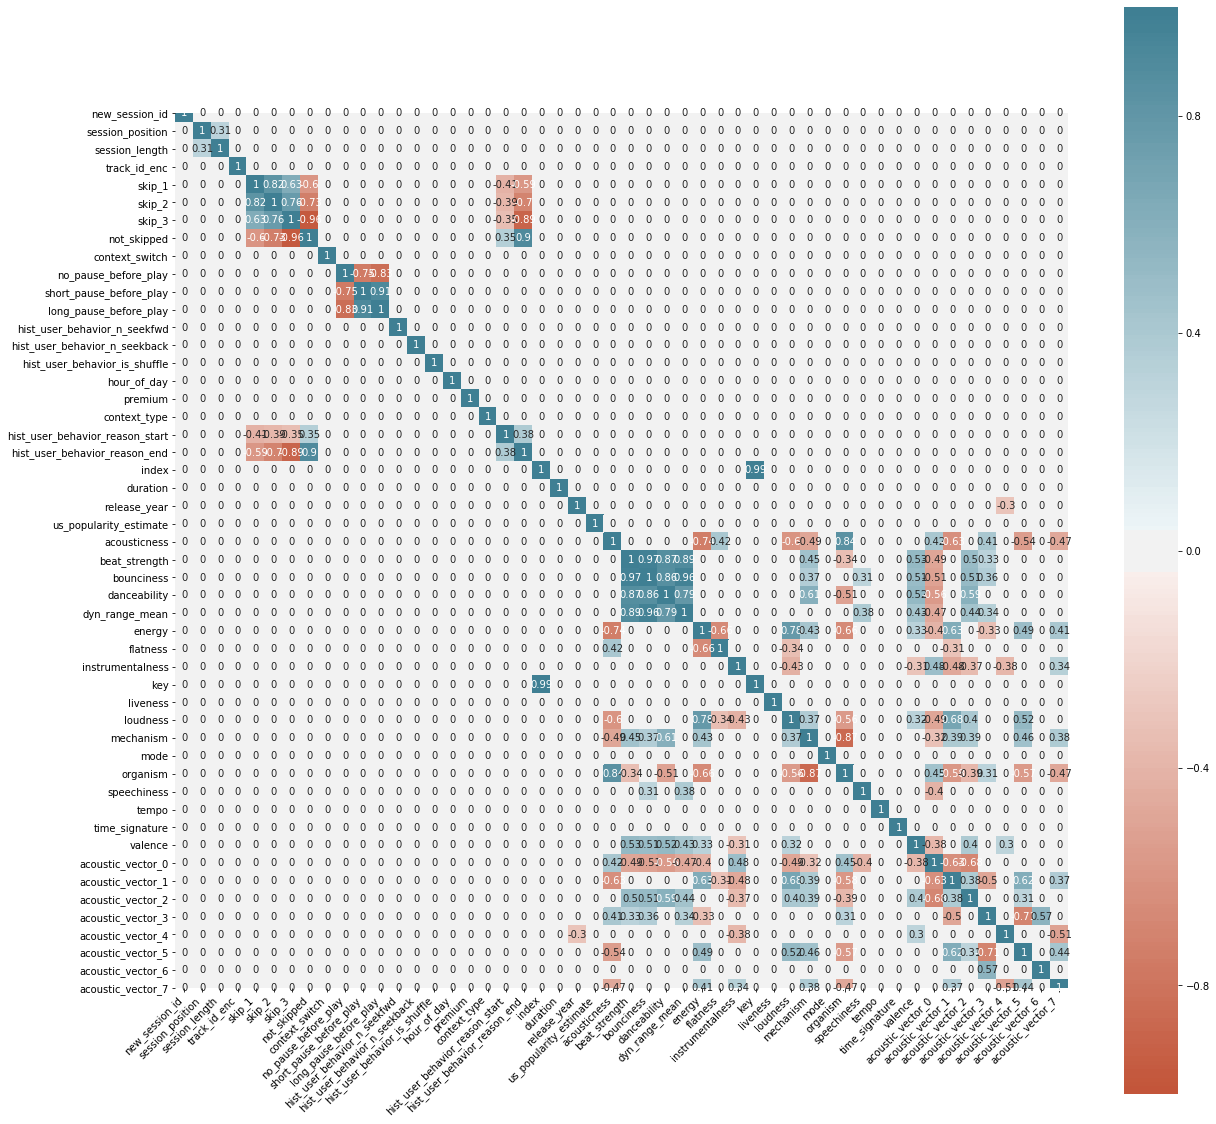

In [0]:
# corr = final_data.corr()
fig, ax = plt.subplots(figsize = (20,20))

subjective_corr = final_data.corr()
subjective_corr[np.abs(subjective_corr)<.3] = 0

ax = sns.heatmap(
    subjective_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Principal-Component Analysis

In [0]:
x_cols  = ["new_session_id", "session_position", "session_length", "track_id_enc", "context_switch", 
                     "us_popularity_estimate","acousticness", "beat_strength", "bounciness", 
                     "danceability", "dyn_range_mean", "energy", "flatness",
                     "instrumentalness", "key", "liveness", "loudness", 
                     "mechanism", "organism", "speechiness", "tempo",
                     "time_signature", "valence", "acoustic_vector_0",
                     "acoustic_vector_1", "acoustic_vector_2", "acoustic_vector_3",
                     "acoustic_vector_4", "acoustic_vector_5", "acoustic_vector_6",
                     "acoustic_vector_7", 'no_pause_before_play', 'short_pause_before_play',
                     'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
                     'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle','premium']

In [0]:
# PCA
x = final_data.loc[:, x_cols].values
y = final_data.loc[:,['skip_2']].values

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

pca.explained_variance_ratio_

array([7.57224360e-01, 2.42775636e-01, 2.87858250e-09, 9.10672805e-10,
       3.64789804e-11])

In [0]:
# Testing the usefulness of the PCA components in prediction
from sklearn.linear_model import LogisticRegression

pca = PCA(.95)
pca.fit(x)
train_img = pca.transform(x)
test_img = y

logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_img, test_img)
logisticRegr.predict(train_img)
logisticRegr.score(train_img, test_img)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5127504130429622

# Gaussian Naive Bayes Model

In [0]:
new_result = final_data.select_dtypes(exclude=['object'])
new_result = new_result.drop(columns=['new_session_id', 'track_id_enc', 'skip_2'])

target = final_data["skip_2"]

np_target = np.array(final_data["skip_2"])

np_target

array([0, 0, 0, ..., 1, 0, 1])

In [0]:
#### GaussianNB

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_result, target, test_size=0.2,random_state=109)


In [0]:
y_test.head()

203044     0
2506162    0
2108023    1
337537     1
1407316    0
Name: skip_2, dtype: int64

In [0]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [0]:
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5906520743259737


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

# TP FP
# FN TN

[[ 46692 244717]
 [   121 306592]]


Text(73.7, 0.5, 'Predicted')

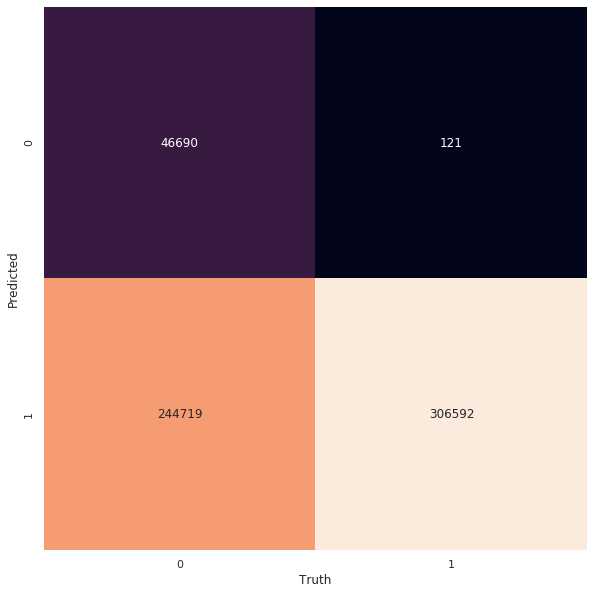

In [0]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize = (10,10))
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar= False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')

In [0]:
#Accuracy = TP+TN/total
matrix = confusion_matrix(y_test, y_pred)
total = matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1]
Accuracy = (matrix[0][0]+matrix[1][1])/total
Error_rate = (matrix[0][1]+matrix[1][0])/total

In [0]:
print(Accuracy)
print(Error_rate)

0.5417389763292438
0.4582610236707561


# Logistic Regression Model

In [0]:
new_result = final_data.select_dtypes(exclude=['object'])
new_result = new_result.drop(columns=['new_session_id', 'track_id_enc','skip_2'])

target = final_data["skip_2"]

np_target = np.array(final_data["skip_2"])

np_target

array([0, 0, 0, ..., 1, 0, 1])

In [0]:
for col in final_data.columns: 
    print(col) 

new_session_id
session_position
session_length
track_id_enc
skip_2
context_switch
no_pause_before_play
short_pause_before_play
long_pause_before_play
hist_user_behavior_n_seekfwd
hist_user_behavior_n_seekback
hist_user_behavior_is_shuffle
hour_of_day
premium
context_type
hist_user_behavior_reason_start
hist_user_behavior_reason_end
index
duration
release_year
us_popularity_estimate
acousticness
beat_strength
bounciness
danceability
dyn_range_mean
energy
flatness
instrumentalness
key
liveness
loudness
mechanism
mode
organism
speechiness
tempo
time_signature
valence
acoustic_vector_0
acoustic_vector_1
acoustic_vector_2
acoustic_vector_3
acoustic_vector_4
acoustic_vector_5
acoustic_vector_6
acoustic_vector_7


**Instantiate Model** 


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_result, target, test_size=0.3,random_state=109)

In [0]:
y_test.head()

203044     0
2506162    0
2108023    0
337537     1
1407316    0
Name: skip_2, dtype: int64

In [0]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#predictions
Predictions = logmodel.predict(X_test)

In [0]:
#evaluation

from sklearn.metrics import classification_report
print(classification_report(y_test,Predictions))

              precision    recall  f1-score   support

           0       0.59      0.42      0.49    437457
           1       0.57      0.72      0.64    459726

    accuracy                           0.57    897183
   macro avg       0.58      0.57      0.56    897183
weighted avg       0.58      0.57      0.56    897183



In [0]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, Predictions))

Accuracy: 0.5743856047205531


**Statmodel Log**

In [0]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(logit_model.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.674648
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 skip_2   No. Observations:              2093426
Model:                          Logit   Df Residuals:                  2093386
Method:                           MLE   Df Model:                           39
Date:                Wed, 06 Nov 2019   Pseudo R-squ.:                 0.02622
Time:                        14:22:33   Log-Likelihood:            -1.4123e+06
converged:                       True   LL-Null:                   -1.4504e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.4534      0.306     -4.744      0.

**Feature Importance**

In [0]:
#feature importance 
from sklearn.preprocessing import StandardScaler

In [0]:
# The estimated coefficients will all be around 1: attribute of the fitted model to see which features are most important. higher absolute value to be more important.
print(logmodel.coef_)

[[-6.15675223e-03  4.60697058e-02 -7.99037337e-01  8.49292233e-01
   7.08618470e-01 -1.80771283e-01  3.08480306e-01 -5.75392706e-01
   2.07166410e-01  5.70801819e-03 -1.72358205e-01  3.42683925e-05
  -6.95635424e-04 -5.24387454e-03 -1.29072082e-02  1.58426551e-02
  -2.82684071e-02  1.43803308e-03 -4.28583405e-03 -1.47879739e-02
  -1.85243407e-02 -2.26017053e-03 -2.59752838e-03 -1.74254547e-02
   6.62551627e-03  2.31251438e-03  5.94024111e-03  1.32152352e-03
   8.82723057e-03 -1.00431684e-02  5.35360044e-03  3.74249911e-03
  -7.71927875e-04  1.83678639e-02 -4.78059356e-03 -1.60147419e-02
  -2.67636458e-02 -1.69856146e-02  1.87445049e-03]]


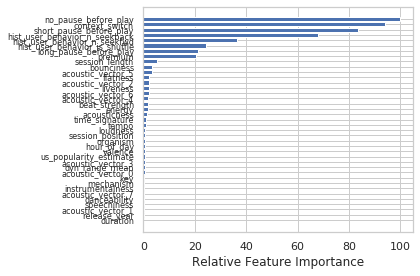

In [0]:
feature_importance = abs(logmodel.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1 ,1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [0]:
print(np.array(X_train.columns)[sorted_idx])

['duration' 'release_year' 'acoustic_vector_1' 'speechiness'
 'danceability' 'acoustic_vector_7' 'instrumentalness' 'mechanism' 'key'
 'acoustic_vector_0' 'dyn_range_mean' 'acoustic_vector_3'
 'us_popularity_estimate' 'valence' 'hour_of_day' 'organism'
 'session_position' 'loudness' 'tempo' 'time_signature' 'acousticness'
 'energy' 'beat_strength' 'acoustic_vector_4' 'acoustic_vector_6'
 'liveness' 'acoustic_vector_2' 'flatness' 'acoustic_vector_5'
 'bounciness' 'session_length' 'premium' 'long_pause_before_play'
 'hist_user_behavior_is_shuffle' 'hist_user_behavior_n_seekfwd'
 'hist_user_behavior_n_seekback' 'short_pause_before_play'
 'context_switch' 'no_pause_before_play']


**Removing features with zero importance**

In [0]:
#removing the coluns that shows 0 
trans_result_2 = trans_result.drop(columns=['duration','release_year', 'acoustic_vector_1' ,'speechiness',
 'danceability','acoustic_vector_7','instrumentalness','mechanism','key'])

In [0]:
new_result_2 = trans_result_2.select_dtypes(exclude=['object'])
new_result_2 = new_result_2.drop(columns=['new_session_id', 'track_id_enc', 'skip_1', 'skip_2', 'skip_3', 'not_skipped'])

target_2 = trans_result_2["skip_2"]

np_target_2 = np.array(trans_result_2["skip_2"])

np_target_2

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
#train the new model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_result_2, target_2, test_size=0.3,random_state=109)

In [0]:
# train new model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#train the new model
Predictions = logmodel.predict(X_test)

In [0]:
#train the new model
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, Predictions))

Accuracy: 0.5731550865319561


**Remove features with zero importance + next feature**


In [0]:
#removing the coluns that shows 0 + next lowest 'acoustic_vector_0'
trans_result_4 = trans_result.drop(columns=['duration','release_year', 'acoustic_vector_1' ,'speechiness',
 'danceability','acoustic_vector_7','instrumentalness','mechanism','key','acoustic_vector_0'])

In [0]:
new_result_4 = trans_result_4.select_dtypes(exclude=['object'])
new_result_4 = new_result_4.drop(columns=['new_session_id', 'track_id_enc', 'skip_1', 'skip_2', 'skip_3', 'not_skipped'])

target_4 = trans_result_4["skip_2"]

np_target_4 = np.array(trans_result_4["skip_2"])

np_target_4

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
#train the new model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_result_4, target_4, test_size=0.3,random_state=109)

In [0]:
# train new model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#train the new model
Predictions = logmodel.predict(X_test)

In [0]:
#train the new model
from sklearn import metrics

# Model Accuracy, how often is the classifier correct
print("Accuracy:",metrics.accuracy_score(y_test, Predictions))

Accuracy: 0.5731272215367433


**Remove all features below importance of 20** 

In [0]:
#removing the coluns that shows below 20 
trans_result_3 = trans_result.drop(columns=['duration','release_year', 'acoustic_vector_1' ,'speechiness',
 'danceability','acoustic_vector_7','instrumentalness','mechanism','key', 'acoustic_vector_0' ,'dyn_range_mean' ,'acoustic_vector_3',
 'us_popularity_estimate' ,'valence' ,'hour_of_day', 'organism', 'session_position' ,'loudness' ,'tempo' ,'time_signature' ,'acousticness',
 'energy', 'beat_strength', 'acoustic_vector_4', 'acoustic_vector_6' , 'liveness' ,'acoustic_vector_2' ,'flatness', 'acoustic_vector_5', 'bounciness' ,'session_length'])

In [0]:
new_result_3 = trans_result_3.select_dtypes(exclude=['object'])
new_result_3 = new_result_3.drop(columns=['new_session_id', 'track_id_enc', 'skip_1', 'skip_2', 'skip_3', 'not_skipped'])

target_3 = trans_result_3["skip_2"]

np_target_3 = np.array(trans_result_3["skip_2"])

np_target_3

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
#train the new model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_result_3, target_3, test_size=0.3,random_state=109)

In [0]:
# train new model
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#train the new model
Predictions = logmodel.predict(X_test)

In [0]:
#train the new model
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, Predictions))

Accuracy: 0.5657563730030551


**Gridsearch - Hypertuning**

In [0]:
# Load libraries
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV


In [0]:
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logmodel, hyperparameters, cv=5, verbose=0)

In [0]:

# Fit grid search
best_model = clf.fit(X_train, y_train)

In [0]:
 
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.001


In [0]:

# View best hyperparameters
print('Best Score: ', best_model.best_score_)
print('Best Params: ', best_model.best_params_)

Best Score:  0.5746116652797854
Best Params:  {'C': 0.001, 'penalty': 'l2'}


# K-nearest Neighbours

**KNN with 46 features**

In [0]:
left_skewed = ['acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_5', 'loudness'] # Exp
right_skewed = ['acousticness', 'instrumentalness', 'liveness', 'speechiness'] # log 

In [0]:
xf_final_data = final_data.copy()

In [0]:
import math
def exponential(x):
  return float(math.exp(x))

def logarithm(x):
  return math.log(x+1)


for col in left_skewed:
  xf_final_data[col].apply(exponential)

for col in right_skewed:
  xf_final_data[col].apply(logarithm)

In [0]:
xf_final_data = final_data.copy()

In [0]:
final_cols = final_data.columns
print(len(final_cols))

47


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

first_half = xf_final_data.loc[lambda x: x.session_position <= (x.session_length/2)].copy()
second_half = xf_final_data.loc[lambda x: x.session_position > (x.session_length/2)].copy()
first_half_labels = first_half['skip_2']
second_half_labels = second_half['skip_2']
first_half.drop(columns=['skip_2'], inplace=True)
second_half.drop(columns=['skip_2'], inplace=True)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(first_half, first_half_labels)

y_pred = knn.predict(second_half)



In [0]:
from sklearn import metrics
acc = metrics.accuracy_score(second_half_labels, y_pred)

print("Accuracy of this KNN model: {}%".format(acc))

Accuracy of this KNN model: 0.5136166906527965%


**KNN with 20 features (SelectKBest)**

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = final_data.drop(columns=['skip_2'])
y = final_data['skip_2']  

bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

                              Specs         Score
15    hist_user_behavior_reason_end  1.508963e+06
3                      track_id_enc  7.285853e+05
16                            index  5.720542e+05
14  hist_user_behavior_reason_start  5.468766e+05
9     hist_user_behavior_n_seekback  2.658098e+04
1                  session_position  2.109660e+04
13                     context_type  1.982957e+04
0                    new_session_id  1.633599e+04
4                    context_switch  1.554118e+04
2                    session_length  1.308398e+04
7            long_pause_before_play  1.247439e+04
5              no_pause_before_play  7.688899e+03
10    hist_user_behavior_is_shuffle  5.234450e+03
6           short_pause_before_play  2.498477e+03
11                      hour_of_day  1.466178e+03
8      hist_user_behavior_n_seekfwd  1.104502e+03
17                         duration  8.952575e+02
29                         liveness  5.248749e+01
12                          premium  4.561756e+01


In [0]:
impt_features = list(featureScores.nlargest(20, 'Score')['Specs'])
print(impt_features)

['hist_user_behavior_reason_end', 'track_id_enc', 'index', 'hist_user_behavior_reason_start', 'hist_user_behavior_n_seekback', 'session_position', 'context_type', 'new_session_id', 'context_switch', 'session_length', 'long_pause_before_play', 'no_pause_before_play', 'hist_user_behavior_is_shuffle', 'short_pause_before_play', 'hour_of_day', 'hist_user_behavior_n_seekfwd', 'duration', 'liveness', 'premium', 'acousticness']


In [0]:
impt_features.extend(['skip_2'])
selected_data = final_data[impt_features]
selected_data.head()

,hist_user_behavior_reason_end,track_id_enc,index,hist_user_behavior_reason_start,hist_user_behavior_n_seekback,session_position,context_type,new_session_id,context_switch,session_length,long_pause_before_play,no_pause_before_play,hist_user_behavior_is_shuffle,short_pause_before_play,hour_of_day,hist_user_behavior_n_seekfwd,duration,liveness,premium,acousticness,skip_2
0,8,5621,176446,8,0,1,2,1,0,20,0,0,1,0,16,0,370.021332,0.125408,1,0.885735,0
1,8,180239,1719983,8,0,2,2,1,0,20,0,1,1,0,16,0,121.666672,0.356001,1,0.015707,0
2,8,314424,955986,8,0,3,2,1,0,20,0,1,1,0,16,0,328.200012,0.057424,1,0.103170,0
3,8,44689,83057,8,0,4,2,1,0,20,0,1,1,0,16,0,226.986664,0.362755,1,0.000003,0
4,8,125848,746179,8,0,5,2,1,0,20,0,1,1,0,16,0,260.119995,0.113737,1,0.549979,0


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

first_half = selected_data.loc[lambda x: x.session_position <= (x.session_length/2)].copy()
second_half = selected_data.loc[lambda x: x.session_position > (x.session_length/2)].copy()
first_half_labels = first_half['skip_2']
second_half_labels = second_half['skip_2']
first_half.drop(columns=['skip_2'], inplace=True)
second_half.drop(columns=['skip_2'], inplace=True)

knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(first_half, first_half_labels)

y_pred = knn.predict(second_half)

In [0]:
from sklearn import metrics
acc = metrics.accuracy_score(second_half_labels, y_pred)

print("Accuracy of this KNN model: {}%".format(acc))

Accuracy of this KNN model: 0.5141140016119734%


**KNN with Neighbourhood Component Analysis**


In [0]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

first_half = final_data.loc[lambda x: x.session_position <= (x.session_length/2)].copy()
second_half = final_data.loc[lambda x: x.session_position > (x.session_length/2)].copy()
first_half_labels = first_half['skip_2']
second_half_labels = second_half['skip_2']
first_half.drop(columns=['skip_2'], inplace=True)
second_half.drop(columns=['skip_2'], inplace=True)


In [0]:

print(__doc__)

n_neighbors = 5
random_state = 0

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=20, random_state=random_state)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)


Automatically created module for IPython interactive environment


In [0]:
plt.figure()

# Fit the method's model
nca.fit(first_half, first_half_labels)



In [0]:
# Fit a nearest neighbor classifier on the embedded training set
knn.fit(nca.transform(first_half), first_half_labels)

print(knn.score(nca.transform(second_half), second_half_labels)) 


In [0]:
knn.fit(first_half, first_half_labels)

print(knn.score(second_half, second_half_labels))

0.509410653535195


# XG BOOST


In [0]:
pd.set_option('display.max_columns', None)
from sklearn import model_selection
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from datetime import datetime
from sklearn import accuracy

In [0]:
# Splitting the data into the first half and second half of the session for train/test
final_data.drop(columns=["mode"], inplace=True)
first_half = final_data.loc[lambda x: x.session_position <= (x.session_length/2)].copy().reset_index(drop=True)
second_half = final_data.loc[lambda x: x.session_position > (x.session_length/2)].copy().reset_index(drop=True)
#first_half.head()
#final_data.sort_values(by=['new_session_id', 'session_position']).reset_index(drop=True)

temp = first_half.pop('skip_2')
first_half['skip_2'] = temp

temp = second_half.pop('skip_2')
second_half['skip_2'] = temp

first_half.sort_values(by=['new_session_id', 'session_position']).reset_index(drop=True)
second_half.sort_values(by=['new_session_id', 'session_position']).reset_index(drop=True)


,new_session_id,session_position,session_length,track_id_enc,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,index,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,skip_2
0,1,11,20,151377,0,1,0,0,0,0,1,16,1,2,4,4,1656703,168.829391,2014,0.647392,0.323170,0.641883,0.668155,0.559222,0.179080,0.628762,0.876473,1.406955e-08,0.909091,0.059895,0.814395,0.195652,0.625660,0.049785,0.387408,0.2,0.747562,0.318728,0.644937,0.784340,0.779941,0.888427,0.594696,0.811632,0.480759,1
1,1,12,20,130876,0,1,0,0,0,0,1,16,1,2,4,4,574278,194.090836,2018,0.460463,0.958094,0.261014,0.265764,0.455236,0.105197,0.238126,0.877353,8.852328e-01,0.181818,0.330391,0.585213,0.335347,0.839734,0.044707,0.479297,0.8,0.217074,0.891345,0.255196,0.425922,0.526546,0.294837,0.585940,0.481997,0.492230,1
2,1,13,20,112073,0,1,0,0,0,0,1,16,1,2,4,4,674998,299.333344,2003,0.733945,0.053530,0.353635,0.310135,0.523729,0.102892,0.574315,0.883008,2.685952e-05,0.363636,0.087427,0.801026,0.668376,0.242570,0.026443,0.547076,0.8,0.407645,0.602450,0.717232,0.591863,0.216927,0.728790,0.854809,0.257733,0.342088,1
3,1,14,20,201043,0,1,0,0,0,0,1,16,1,2,4,8,816134,155.933334,2002,0.480712,0.826501,0.542504,0.554681,0.632070,0.153875,0.493754,0.814441,2.657431e-06,0.454545,0.092815,0.738076,0.376307,0.745771,0.226046,0.499186,0.8,0.910566,0.507963,0.327988,0.607364,0.694250,0.813079,0.480664,0.310021,0.171231,0
4,1,15,20,169442,0,1,0,0,0,0,1,16,1,2,8,4,976382,246.666672,2009,0.655580,0.005256,0.222384,0.180649,0.469859,0.080423,0.927033,0.777099,1.898532e-02,0.545455,0.173612,0.731543,0.806527,0.139776,0.089108,0.500002,0.8,0.137879,0.587873,0.634869,0.537917,0.292079,0.417406,0.869796,0.470153,0.673797,1
5,1,16,20,273363,0,0,1,1,0,0,1,16,1,2,4,4,1473661,192.748840,2011,0.081496,0.024161,0.892591,0.900966,0.872770,0.246606,0.408760,0.883965,1.247119e-08,0.818182,0.044443,0.722203,0.958333,0.034747,0.179226,0.305088,0.8,0.737479,0.117616,0.717280,0.725539,0.509185,0.371780,0.690218,0.122514,0.554905,1
6,1,17,20,239225,0,1,0,0,0,0,1,16,1,2,4,4,190988,136.337097,2017,0.905140,0.892866,0.241525,0.202711,0.308086,0.085586,0.121571,0.906616,9.828346e-01,0.000000,0.099464,0.621894,0.449580,0.755193,0.038295,0.517671,0.8,0.071118,0.891130,0.279963,0.402545,0.491490,0.303158,0.634855,0.495030,0.582159,1
7,1,18,20,238364,0,1,0,0,0,0,1,16,1,2,4,4,930371,273.872955,2018,0.452851,0.273744,0.242794,0.223471,0.337946,0.093964,0.844737,0.811091,4.620569e-01,0.454545,0.277905,0.810306,0.284483,0.552970,0.047370,0.358603,0.8,0.637317,0.636926,0.586878,0.406455,0.192477,0.809181,0.842755,0.170108,0.373495,1
8,1,19,20,20415,0,1,0,0,0,0,1,16,1,2,4,4,714630,228.039993,2012,0.833919,0.223607,0.631829,0.638938,0.795768,0.168912,0.857380,0.819365,1.402287e-07,0.363636,0.335710,0.853278,0.829327,0.202613,0.080992,0.496066,0.8,0.886873,0.458940,0.780666,0.784277,0.334950,0.372354,0.851949,0.532348,0.464003,1
9,1,20,20,66971,0,1,0,0,0,0,1,16,1,2,4,4,1442320,317.333344,2005,0.359014,0.479869,0.452355,0.436427,0.486517,0.128737,0.423981,0.879211,1.616790e-05,0.818182,0.110791,0.734862,0.280125,0.624001,0.027217,0.550453,0.8,0.429499,0.678143,0.559441,0.513446,0.196670,0.736558,0.874056,0.175737,0.300584,1


In [0]:
from sklearn.model_selection import train_test_split

def split_data(user_df):
    train_df, test_df = train_test_split(user_df, test_size=0.2, random_state=123)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    train_labels = list(train_df["skip_2"])
    train_df.drop(columns=["skip_2"], inplace=True)
    
    test_labels = list(test_df["skip_2"])
    test_df.drop(columns=["skip_2"], inplace=True)
    return train_df, test_df, train_labels, test_labels

def accuracy(x, y):
    total = 0
    length = len(x)
    for num in range(length):
        if x[num] == y[num]:
            total += 1
    return total/length * 100


#from sklearn.ensemble import RandomForestClassifier
def predict_result(model, X_train, X_test, y_train):

    model.fit(X_train,y_train)

    # predictions
    predicted = model.predict(X_test)
    
    return predicted

def round_up(predicted):
    for i in range(len(predicted)):
        if predicted[i] >= 0.5:
            predicted[i] = 1
        else:
            predicted[i] = 0
    return predicted

def scale_importance(final_importances):
    length = len(importances)
    for i in range(len(final_importances)):
        final_importances[i] = final_importances[i]/length
    return final_importances

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [0]:
## Change Model Here ## 
model = xgb.XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.2,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None,
                           tree_method='exact',
                           nthread=4)

In [0]:
X_train = first_half.iloc[:,:-1]
y_train = first_half.iloc[:,-1]

X_test = second_half.iloc[:,:-1]
y_test = second_half.iloc[:,-1]

In [0]:
start_time = timer(None)
predicted = predict_result(model, X_train, X_test, y_train)
timer(start_time)

accuracy = accuracy_score(y_test, predicted)
print("Accuracy of initial XGBoost Model: " + str(accuracy))


 Time taken: 0 hours 16 minutes and 52.03 seconds.
Accuracy of initial XGBoost Model: 0.8867865665361171


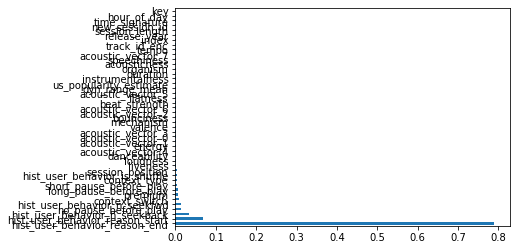

In [0]:
importance = model.feature_importances_ 
importance = pd.Series(importance, index=X_train.columns)
importance.nlargest(50).plot(kind='barh')

In [0]:
importance.sort_values(axis=0,ascending=False, inplace=True)

selected_features = importance.index[0:20].tolist()

selected_features.insert(0,'new_session_id')

selected_features.insert(len(selected_features),'skip_2')

print(selected_features)

first_half_impt = first_half[selected_features]

second_half_impt = second_half[selected_features]

['new_session_id', 'hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'hist_user_behavior_n_seekback', 'no_pause_before_play', 'hist_user_behavior_n_seekfwd', 'context_switch', 'premium', 'long_pause_before_play', 'short_pause_before_play', 'context_type', 'hist_user_behavior_is_shuffle', 'session_position', 'liveness', 'loudness', 'danceability', 'acoustic_vector_4', 'energy', 'acoustic_vector_1', 'acoustic_vector_0', 'acoustic_vector_3', 'skip_2']


In [0]:
X_train = first_half_impt.iloc[:,:-1]
y_train = first_half_impt.iloc[:,-1]

X_test = second_half_impt.iloc[:,:-1]
y_test = second_half_impt.iloc[:,-1]

In [0]:
start_time = timer(None)
predicted = predict_result(model, X_train, X_test, y_train)
timer(start_time)

accuracy = accuracy_score(y_test, predicted)
print("Accuracy of XGBoost with selected important features: " + str(accuracy))


 Time taken: 0 hours 8 minutes and 2.27 seconds.
Accuracy of XGBoost with selected important features: 0.8867212697390898


In [0]:
params = {
        'max_depth': [5,7],
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1]
        }

**K-fold**

In [0]:
from sklearn.model_selection import KFold
folds = 3
param_comb = 3

kf = KFold(n_splits=folds, shuffle = False, random_state = None)

grid = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', n_jobs=3, cv=kf.split(X_train,y_train), 
                    verbose=3 )

start_time = timer(None)

grid.fit(X_train, y_train)

print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_)
print('\n Best parameters:')
print(grid.best_params_)

timer(start_time)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed: 80.8min finished



 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=500, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1,
              silent=True, subsample=1, tree_method='exact', verbosity=1)

 Best score:
0.8655286190490724

 Best parameters:
{'gamma': 1, 'max_depth': 5, 'min_child_weight': 5}

 Time taken: 1 hours 26 minutes and 5.74 seconds.


# LSTM

**Split into train and test (before/after sequence)**


In [0]:
first_half = first_half[first_half['session_length']==20]
y_train = np.array(first_half[['skip_2']])
xtrain_df = first_half.drop(columns='skip_2',axis=1)
x_train = xtrain_df.values

second_half = second_half[second_half['session_length']==20]
y_test = np.array(second_half[['skip_2']])
xtest_df = second_half.drop(columns='skip_2',axis=1)
x_test = xtest_df.values

In [0]:
num_sessions = xtrain_df['new_session_id'].nunique()
print(num_sessions)

89672


In [0]:
xtrain_df = xtrain_df[xtrain_df['session_length']==20]

**Preprocess track and session features**


In [0]:
track_f = xtrain_df.copy().drop(columns=[
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end','new_session_id', 'session_position', 'session_length'],axis=1)

In [0]:
sess_f = xtrain_df.copy()

In [0]:
sess_f = sess_f.drop(columns=['track_id_enc', 'index', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism', 'mode',
       'organism', 'speechiness', 'tempo', 'time_signature', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7','new_session_id', 'session_position', 'session_length'],axis=1)

In [0]:
track_f.columns

Index(['track_id_enc', 'index', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism', 'mode',
       'organism', 'speechiness', 'tempo', 'time_signature', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7'],
      dtype='object')

In [0]:
cat_size = []
for i in sess_f.columns:
  num = sess_f.nunique()
  cat_size.append(num)

In [0]:
import numpy as np
cat_size = [2,2,2,2,41,47,2,24,2,6,10,9]
embd_size = []
for i in cat_size:
  embd_size.append(int(min(np.ceil((i)/2), 50 )))

**Instantiate Model**

In [0]:
cat_size = [2,2,2,2,41,47,2,24,2,6,10,9]
num_cats = 12
num_feats = 31
cat_embd_dim = embd_size
n_steps = 89672

numerical_input = Input(shape=(n_steps, num_feats*10), name='numeric_input')
# numerical_input = Reshape((n_steps, -1))(numerical_input)

cat_inputs = []
for i in range(num_cats):
    cat_inputs.append(Input(shape=(n_steps,10), name='cat' + str(i+1) + '_input'))

cat_embedded = []
for i in range(num_cats):
    embed = TimeDistributed(Embedding(1, cat_embd_dim[i]))(cat_inputs[i])
    embed = Embedding(cat_embd_dim[i], cat_size[i])(cat_inputs[i])
    cat_embedded.append(embed)

cat_merged = concatenate(cat_embedded)
cat_merged = Reshape((n_steps, -1))(cat_merged)
merged = concatenate([numerical_input, cat_merged])
lstm_out = LSTM(64, return_sequences=True)(merged)
dropout1 = Dropout(0.2)(lstm_out)
lstm_out2 = LSTM(64,return_sequences=True)(dropout1)
dropout2 = Dropout(0.2)(lstm_out2)
lstm_out3 = LSTM(64,return_sequences=True)(dropout2)
lstm_output = Dense(10, activation='softmax')(lstm_out3)

model = Model([numerical_input] + cat_inputs, lstm_output)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat1_input (InputLayer)         (None, 89672, 10)    0                                            
__________________________________________________________________________________________________
cat2_input (InputLayer)         (None, 89672, 10)    0                                            
__________________________________________________________________________________________________
cat3_input (InputLayer)         (None, 89672, 10)    0                                            
__________________________________________________________________________________________________
cat4_input (InputLayer)         (None, 89672, 10)    0                  

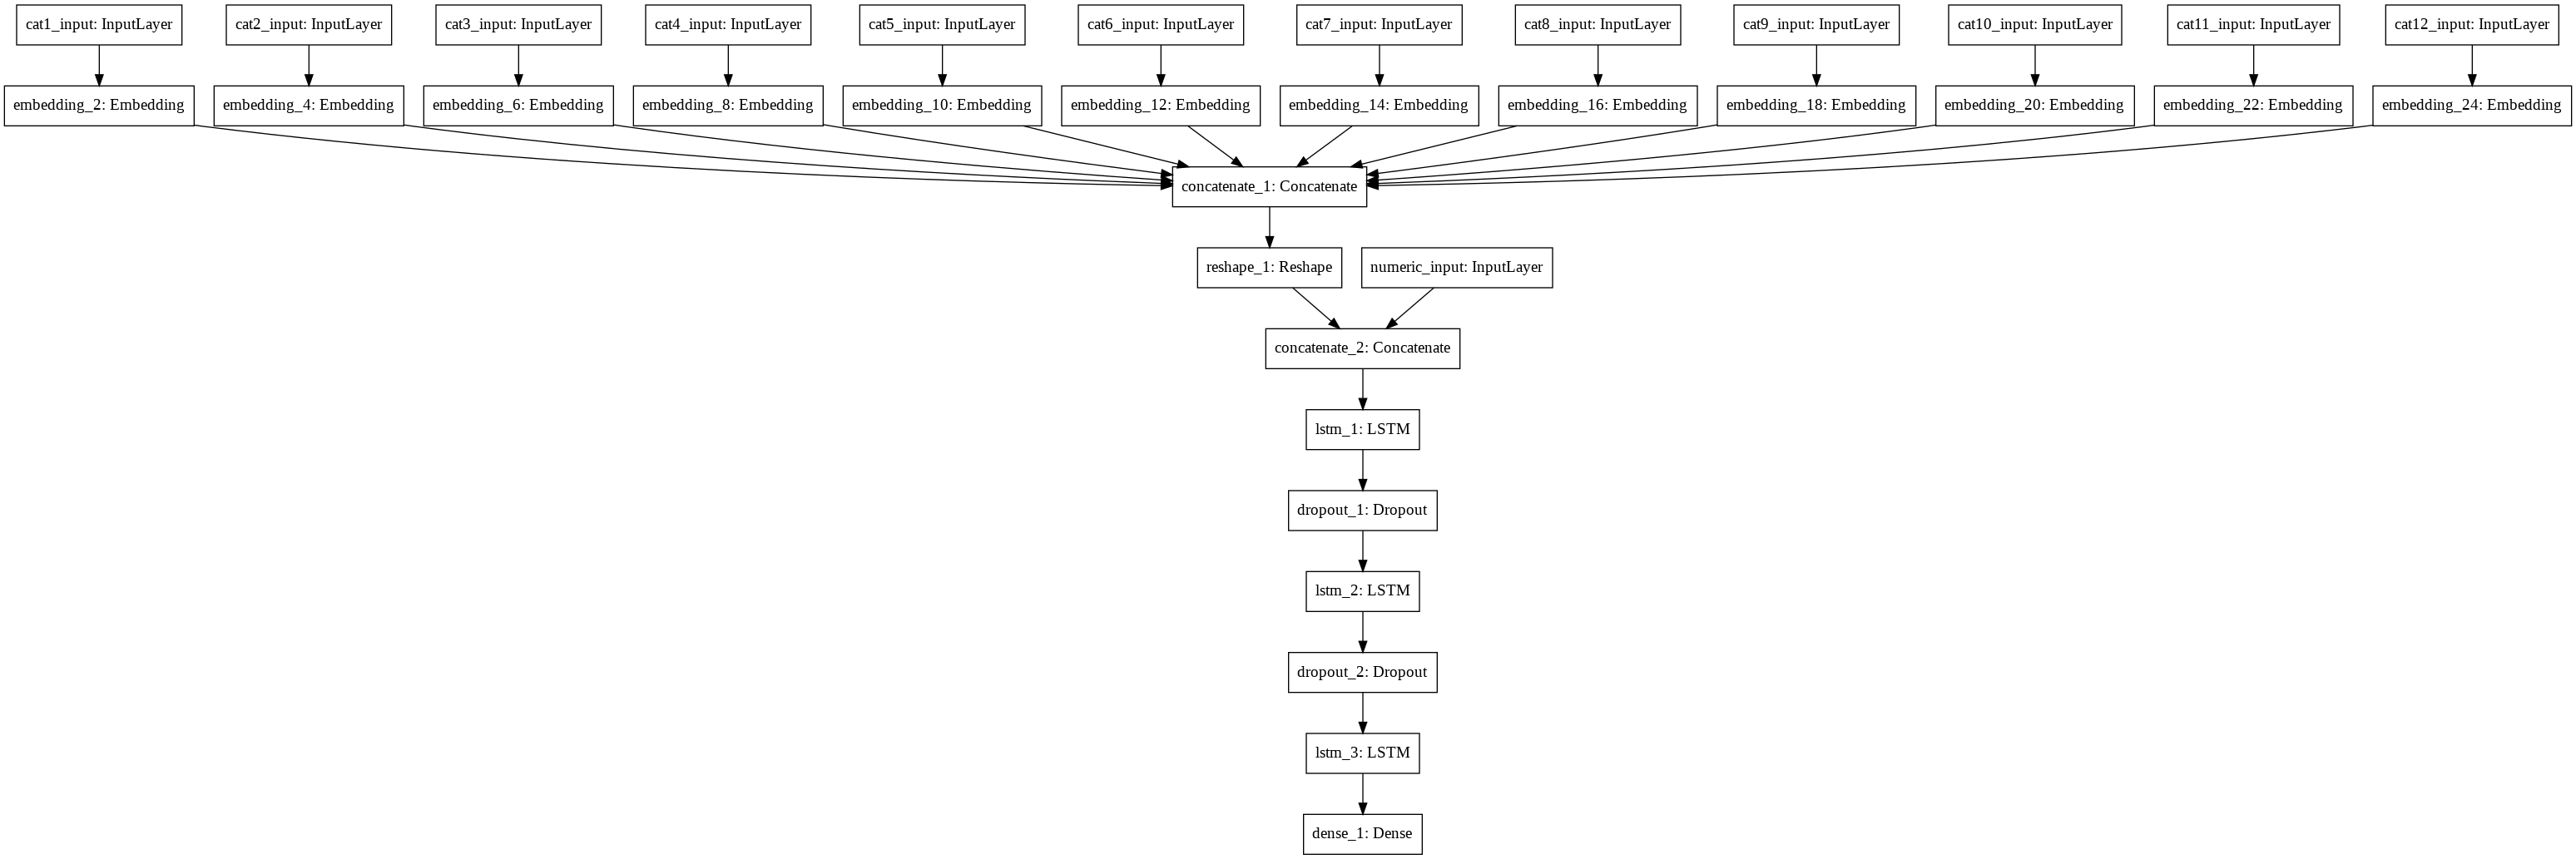

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
sess_values = sess_f.values
track_values = track_f.values

In [0]:
# test = track_values.reshape(89672,310)
test = track_values[:,:num_feats]
test = test.reshape(89672,310)

In [0]:
y_train = y_train.reshape(89672,10)

**Model with batch size: 128 and epochs: 5**

In [0]:
X_tr_numerical = track_values[:,:num_feats]
X_tr_numerical = X_tr_numerical.reshape(89672,310)

X_tr_cat1 = sess_values[:,0].reshape(n_steps,10) 
X_tr_cat2 = sess_values[:,1].reshape(n_steps,10)
X_tr_cat3 = sess_values[:,2].reshape(n_steps,10)
X_tr_cat4 = sess_values[:,3].reshape(n_steps,10) 
X_tr_cat5 = sess_values[:,4].reshape(n_steps,10)
X_tr_cat6 = sess_values[:,5].reshape(n_steps,10)
X_tr_cat7 = sess_values[:,6].reshape(n_steps,10) 
X_tr_cat8 = sess_values[:,7].reshape(n_steps,10)
X_tr_cat9 = sess_values[:,8].reshape(n_steps,10)
X_tr_cat10 = sess_values[:,9].reshape(n_steps,10) 
X_tr_cat11 = sess_values[:,10].reshape(n_steps,10)
X_tr_cat12 = sess_values[:,11].reshape(n_steps,10)

# compile the model ...
model.compile('nadam','binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit([[X_tr_numerical], [X_tr_cat1], [X_tr_cat2], [X_tr_cat3],[X_tr_cat4],[X_tr_cat5],[X_tr_cat6],[X_tr_cat7],[X_tr_cat8],[X_tr_cat9],[X_tr_cat10],[X_tr_cat11], [X_tr_cat12]], [[y_train]],batch_size=128,epochs=5)




Epoch 1/5





1/1 [==============================] - 491s 491s/step - loss: 1.2713 - acc: 0.4740
Epoch 2/5
1/1 [==============================] - 486s 486s/step - loss: 1.2618 - acc: 0.4740
Epoch 3/5
1/1 [==============================] - 477s 477s/step - loss: 1.2586 - acc: 0.4740
Epoch 4/5
1/1 [==============================] - 493s 493s/step - loss: 1.2583 - acc: 0.4740
Epoch 5/5
1/1 [==============================] - 485s 485s/step - loss: 1.2583 - acc: 0.4740


**Model with batch size: 32 and epochs: 5**

In [0]:
X_tr_numerical = track_values[:,:num_feats]
X_tr_numerical = X_tr_numerical.reshape(89672,310)


X_tr_cat1 = sess_values[:,0].reshape(n_steps,10) 
X_tr_cat2 = sess_values[:,1].reshape(n_steps,10)
X_tr_cat3 = sess_values[:,2].reshape(n_steps,10)
X_tr_cat4 = sess_values[:,3].reshape(n_steps,10) 
X_tr_cat5 = sess_values[:,4].reshape(n_steps,10)
X_tr_cat6 = sess_values[:,5].reshape(n_steps,10)
X_tr_cat7 = sess_values[:,6].reshape(n_steps,10) 
X_tr_cat8 = sess_values[:,7].reshape(n_steps,10)
X_tr_cat9 = sess_values[:,8].reshape(n_steps,10)
X_tr_cat10 = sess_values[:,9].reshape(n_steps,10) 
X_tr_cat11 = sess_values[:,10].reshape(n_steps,10)
X_tr_cat12 = sess_values[:,11].reshape(n_steps,10)

#compile the model ...
model.compile('nadam','binary_crossentropy', metrics=['accuracy'])
# fit the model
model.fit([[X_tr_numerical], [X_tr_cat1], [X_tr_cat2], [X_tr_cat3],[X_tr_cat4],[X_tr_cat5],[X_tr_cat6],[X_tr_cat7],[X_tr_cat8],[X_tr_cat9],[X_tr_cat10],[X_tr_cat11], [X_tr_cat12]], [[y_train]],batch_size=32,epochs=5)




Epoch 1/5





1/1 [==============================] - 418s 418s/step - loss: 1.2649 - acc: 0.4740
Epoch 2/5
1/1 [==============================] - 420s 420s/step - loss: 1.2598 - acc: 0.4740
Epoch 3/5
1/1 [==============================] - 422s 422s/step - loss: 1.2588 - acc: 0.4740
Epoch 4/5
1/1 [==============================] - 421s 421s/step - loss: 1.2591 - acc: 0.4740
Epoch 5/5
1/1 [==============================] - 420s 420s/step - loss: 1.2593 - acc: 0.4740
